## 데이터마이닝 프로젝트

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


In [56]:
# 데이터 로드

FP_PATH    = "floating_population.csv"   # 유동인구
SALES_PATH = "sales.csv"                 # 매출
STORE_PATH = "store.csv"                 # 점포


In [57]:
def read_korean_csv(path: str) -> pd.DataFrame:
    """Try common Korean encodings."""
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

fp    = read_korean_csv(FP_PATH)
fp = fp[fp["기준_년분기_코드"] // 10 == 2024]
sales = read_korean_csv(SALES_PATH)
store = read_korean_csv(STORE_PATH)

f = lambda x: display(x["기준_년분기_코드"].unique())
f(fp)
f(sales)
f(store)


array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

In [58]:
# 열 확인

def get_columns(df):
    display(df.columns)
get_columns(fp)
get_columns(sales)
get_columns(store)

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
       '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
       '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수',
       '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수',
       '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수', '여성_매출_건수',
       '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수',
       '연령대_50_매출_건수', '연령대_60_이상_매출_건수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '점포_수',
       '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수'],
      dtype='object')

In [59]:
#데이터 전처리
def make_numeric(df, drop_cols):
    return [c for c in df.columns if c not in drop_cols and df[c].dtype != 'object']

sales_num = make_numeric(sales, ["행정동_코드", "기준_년분기_코드"])
store_num = make_numeric(store, ["행정동_코드", "기준_년분기_코드"])

sales_agg = (sales
             .groupby(["기준_년분기_코드", "행정동_코드"])[sales_num]
             .sum()
             .reset_index())

store_agg = (store
             .groupby(["기준_년분기_코드", "행정동_코드"])[store_num]
             .median() # 0 값이 많아 median과 차이가 있는데 어떤 걸로 할지?
             .reset_index())

# merged 건들면 안됨!
merged = (fp
          .merge(sales_agg, on=["기준_년분기_코드", "행정동_코드"], how="left")
          .merge(store_agg, on=["기준_년분기_코드", "행정동_코드"], how="left"))
merged = merged.dropna(axis=0)
merged.isna().sum().sum()


0

In [60]:
seoul_gu_code_map = {
    '11110': '종로구',
    '11140': '중구',
    '11170': '용산구',
    '11200': '성동구',
    '11215': '광진구',
    '11230': '동대문구',
    '11260': '중랑구',
    '11290': '성북구',
    '11305': '강북구',
    '11320': '도봉구',
    '11350': '노원구',
    '11380': '은평구',
    '11410': '서대문구',
    '11440': '마포구',
    '11470': '양천구',
    '11500': '강서구',
    '11530': '구로구',
    '11545': '금천구',
    '11560': '영등포구',
    '11590': '동작구',
    '11620': '관악구',
    '11650': '서초구',
    '11680': '강남구',
    '11710': '송파구',
    '11740': '강동구'
}

import pandas as pd

# 예시 DataFrame
# merged = pd.read_csv("your_file.csv")  # 실제 사용할 때

# 행정동_코드를 문자열로 변환
merged['행정동_코드'] = merged['행정동_코드'].astype(str)

# 시군구 코드 추출 (앞 5자리)
merged['시군구코드'] = merged['행정동_코드'].str[:5]

# 자치구명 매핑
merged['자치구'] = merged['시군구코드'].map(seoul_gu_code_map)

# 결과 확인
print(merged[['행정동_코드', '시군구코드', '자치구']])

        행정동_코드  시군구코드  자치구
0     11350619  11350  노원구
1     11350621  11350  노원구
2     11350624  11350  노원구
3     11350625  11350  노원구
4     11350630  11350  노원구
...        ...    ...  ...
1695  11620585  11620  관악구
1696  11620595  11620  관악구
1697  11110515  11110  종로구
1698  11110530  11110  종로구
1699  11110540  11110  종로구

[1696 rows x 3 columns]


In [61]:
selected_df = pd.DataFrame()
selected_df["총_유동인구_수"] = merged["총_유동인구_수"]
selected_df["청년층_유동인구_비율"] = (merged["연령대_20_유동인구_수"] + merged["연령대_30_유동인구_수"])/merged["총_유동인구_수"]
selected_df["청년_매출_비율"] = (merged["연령대_20_매출_건수"] + merged["연령대_30_매출_건수"]) / merged["당월_매출_건수"]
selected_df["주말_매출_비율"] =  merged["주중_매출_건수"]/ merged["주말_매출_건수"]
selected_df["행정동_코드"] = merged["행정동_코드"]
selected_df["야간유동인구비율"] = (merged["시간대_17_21_유동인구_수"] 
                            + merged["시간대_21_24_유동인구_수"] 
                            + merged["시간대_00_06_유동인구_수"]) / merged["총_유동인구_수"]
selected_df["점포당_월매출액"] = merged["당월_매출_금액"] / merged["유사_업종_점포_수"]
selected_df["객단가"] = merged["당월_매출_금액"] / merged["당월_매출_건수"]
selected_df["개업_율"] = merged["개업_율"]
selected_df["프랜차이즈_점포_비율"] = merged["프랜차이즈_점포_수"] / merged["유사_업종_점포_수"]


# 4.1 이상치 처리
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# 이상치가 많이 발생할 수 있는 변수들 선택
outlier_columns = ['총_유동인구_수', '청년층_유동인구_비율', '청년_매출_비율', '주말_매출_비율', '야간유동인구비율', '점포당_월매출액', '객단가', '개업_율', '프랜차이즈_점포_비율']
selected_df = remove_outliers(selected_df, outlier_columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_df)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)


In [62]:
# 클러스터 로직
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
selected_df['cluster'] = kmeans.fit_predict(X_pca2)

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

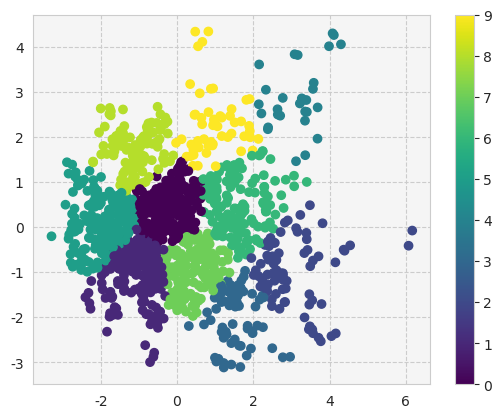

In [63]:
# 2d 시각화
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=selected_df['cluster'], cmap='viridis')
plt.colorbar()
plt.show()


=== 클러스터별 평균 통계 ===


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율
cluster,,,,,,,,,
0,4819653.02,0.28,0.29,3.05,0.56,4.775723e+09,23970.16,0.0,0.0
1,4926877.52,0.27,0.30,2.86,0.58,3.310179e+09,18532.17,0.0,0.0
2,7637015.76,0.43,0.47,2.75,0.56,6.823853e+09,24033.05,0.0,0.0
3,6829389.97,0.39,0.44,2.52,0.57,4.961857e+09,18832.88,0.0,0.0
4,6348257.24,0.36,0.40,3.89,0.51,8.563297e+09,32421.92,0.0,0.0
5,3112735.65,0.24,0.25,3.23,0.58,2.774483e+09,20124.12,0.0,0.0
6,6359830.21,0.33,0.37,3.10,0.55,6.418578e+09,25867.19,0.0,0.0
7,6605318.02,0.32,0.36,2.94,0.57,4.482716e+09,20137.39,0.0,0.0
8,2970505.90,0.23,0.23,3.35,0.56,4.679664e+09,27137.72,0.0,0.0



=== 클러스터별 샘플 데이터 (원래 스케일) ===

클러스터 8의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1525,2178458,0.208345,0.184637,3.710009,11320681,0.573670,4.685631e+09,22408.134993,0.0,0.0,8
1324,3374242,0.280342,0.229311,3.281434,11680690,0.552647,5.568837e+09,29126.126900,0.0,0.0,8
611,2097951,0.225090,0.261637,3.265562,11740560,0.530132,4.592449e+09,21325.783696,0.0,0.0,8
1131,3402768,0.228006,0.261007,3.904791,11740520,0.564957,2.456826e+09,23245.928495,0.0,0.0,8
71,4331414,0.201374,0.231080,3.207449,11470630,0.562094,3.990791e+09,24525.356310,0.0,0.0,8
590,3204294,0.261709,0.305490,3.190740,11710590,0.540595,3.765760e+09,24579.669205,0.0,0.0,8
1021,3137012,0.257350,0.204450,3.190824,11560670,0.560573,4.511793e+09,34160.064528,0.0,0.0,8
217,5397881,0.258534,0.242721,3.973073,11710520,0.564964,4.450245e+09,31979.381229,0.0,0.0,8
850,4394528,0.277202,0.218647,3.865364,11290770,0.557725,2.722914e+09,21227.586938,0.0,0.0,8
1481,1647565,0.232283,0.266017,3.503053,11260690,0.566324,5.779409e+09,20612.525561,0.0,0.0,8



클러스터 5의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1,3820017,0.171990,0.207720,2.454150,11350621,0.567679,1.992533e+09,28926.477805,0.0,0.0,5
738,2577404,0.232955,0.233383,3.158001,11290590,0.602603,2.716421e+09,16187.480975,0.0,0.0,5
1008,3452646,0.244521,0.265797,3.095835,11545710,0.584410,4.481782e+09,17181.715068,0.0,0.0,5
266,1834716,0.231705,0.275796,3.261710,11110570,0.524226,3.638250e+09,14755.204184,0.0,0.0,5
481,1625814,0.202177,0.227489,3.382123,11545680,0.586879,1.583446e+09,27020.954545,0.0,0.0,5
1134,3729983,0.178564,0.227296,3.573596,11740550,0.561291,1.735259e+09,17315.398374,0.0,0.0,5
1656,2144078,0.239324,0.280996,3.195731,11545700,0.598437,2.563342e+09,15778.256471,0.0,0.0,5
81,3449941,0.271013,0.294438,3.240839,11500550,0.580997,2.775366e+09,23627.627222,0.0,0.0,5
1273,4911434,0.235048,0.281601,3.078993,11260680,0.575096,3.596797e+09,23302.260066,0.0,0.0,5
482,1196045,0.250614,0.244494,3.515684,11545690,0.566546,2.265169e+09,19542.110882,0.0,0.0,5



클러스터 0의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1327,2573034,0.302648,0.323671,3.413915,11680730,0.559231,5.509081e+09,25909.945183,0.0,0.0,0
36,3915677,0.257563,0.240310,2.650012,11410660,0.573689,4.534206e+09,27850.258557,0.0,0.0,0
1457,5763551,0.273258,0.288196,3.582283,11230610,0.571325,3.707254e+09,20914.364075,0.0,0.0,0
746,5133575,0.245978,0.318645,3.030015,11290685,0.571090,3.259308e+09,23081.563633,0.0,0.0,0
804,5559726,0.258470,0.321103,3.004911,11380552,0.576167,8.067765e+09,22803.354406,0.0,0.0,0
346,6515295,0.273456,0.282747,3.433937,11230610,0.568312,3.725415e+09,20747.523722,0.0,0.0,0
402,4173211,0.266775,0.226530,2.196216,11305645,0.574886,6.958073e+09,23050.644015,0.0,0.0,0
987,7132853,0.258369,0.266206,2.733929,11530550,0.559512,5.731371e+09,18489.930178,0.0,0.0,0
257,6801827,0.289094,0.281054,2.778296,11740660,0.561427,4.482173e+09,26406.888991,0.0,0.0,0
211,3535118,0.234787,0.356055,3.016775,11680700,0.570458,4.042464e+09,24936.704496,0.0,0.0,0



클러스터 7의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
116,3737258,0.303646,0.382754,2.206900,11545640,0.587634,4.352555e+09,20933.216225,0.0,0.0,7
1620,7841089,0.331812,0.342392,2.608245,11500590,0.592991,5.254403e+09,20216.552314,0.0,0.0,7
290,3659171,0.280696,0.444316,3.213382,11140665,0.537493,5.181598e+09,16990.350082,0.0,0.0,7
829,11111536,0.281148,0.304900,2.990649,11410720,0.584993,5.946673e+09,23779.273570,0.0,0.0,7
161,8955442,0.339038,0.382733,2.953443,11620605,0.572759,4.766482e+09,24456.871387,0.0,0.0,7
1212,3290351,0.376152,0.373468,3.249450,11200790,0.560008,5.616143e+09,18543.275768,0.0,0.0,7
155,3916844,0.384659,0.400949,3.153078,11620525,0.550050,2.739965e+09,19176.597478,0.0,0.0,7
135,5065983,0.303212,0.355393,3.173432,11560680,0.571216,5.633222e+09,18569.907768,0.0,0.0,7
1216,4435244,0.324655,0.358718,3.522055,11215750,0.596255,4.350260e+09,23154.048573,0.0,0.0,7
39,6327613,0.338191,0.381610,3.165040,11410700,0.561690,3.236219e+09,19849.976860,0.0,0.0,7



클러스터 2의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1462,5912753,0.470849,0.481265,2.745870,11230720,0.557931,4.339879e+09,22161.184698,0.0,0.0,2
1159,8439896,0.467958,0.540488,2.357076,11110650,0.543399,5.972038e+09,19272.901874,0.0,0.0,2
272,8621484,0.460945,0.550004,2.263331,11110650,0.544739,6.035128e+09,19776.398282,0.0,0.0,2
414,4510338,0.478356,0.588419,2.416009,11440680,0.532714,7.836877e+09,29895.743971,0.0,0.0,2
51,4716787,0.477535,0.580356,2.466062,11440680,0.536332,7.539022e+09,29470.998991,0.0,0.0,2
338,7446093,0.385656,0.422797,3.103711,11215850,0.588295,8.015213e+09,30313.191910,0.0,0.0,2
635,9687330,0.486931,0.535619,2.593069,11110650,0.541783,6.291293e+09,18495.522216,0.0,0.0,2
123,11193916,0.454124,0.513194,1.989410,11560535,0.508311,1.148205e+10,28889.678407,0.0,0.0,2
892,10347182,0.283413,0.447824,2.392248,11350640,0.551069,5.509529e+09,23349.030837,0.0,0.0,2
46,7603223,0.459151,0.470164,3.426934,11440600,0.533392,6.773456e+09,21219.278012,0.0,0.0,2



클러스터 1의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
536,7246114,0.348411,0.176202,3.067457,11620745,0.578746,2.972902e+09,21459.961686,0.0,0.0,1
791,4160171,0.229551,0.253297,2.554879,11350625,0.572001,6.010716e+09,19644.605456,0.0,0.0,1
1523,4445490,0.257805,0.304364,2.896273,11320670,0.565059,4.395365e+09,19475.247553,0.0,0.0,1
1032,5544428,0.300717,0.278737,3.072851,11590560,0.596640,3.533565e+09,18318.337450,0.0,0.0,1
959,7300318,0.231767,0.311420,2.883981,11470640,0.596477,5.560493e+09,17524.426070,0.0,0.0,1
368,4104110,0.260441,0.325744,2.631966,11260660,0.586195,3.425823e+09,17128.364689,0.0,0.0,1
901,6017433,0.275735,0.230903,2.680372,11380530,0.580176,5.141839e+09,19587.173084,0.0,0.0,1
1518,3679758,0.252039,0.297380,2.671121,11320514,0.560944,3.382733e+09,19189.863401,0.0,0.0,1
992,7666396,0.253286,0.270131,2.872810,11530740,0.572881,3.431846e+09,19195.905638,0.0,0.0,1
865,8245053,0.247772,0.287463,3.027047,11305660,0.580106,3.030986e+09,19558.103759,0.0,0.0,1



클러스터 6의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
256,8725558,0.306529,0.436953,2.836596,11740650,0.571255,6.508299e+09,24661.381708,0.0,0.0,6
1177,3686931,0.283051,0.340530,2.879711,11140665,0.537411,8.310722e+09,23485.173401,0.0,0.0,6
1117,8263765,0.314815,0.362123,3.446172,11710620,0.547789,5.221400e+09,25487.030142,0.0,0.0,6
286,4126349,0.343267,0.386931,3.415922,11140625,0.540421,6.363982e+09,27918.607846,0.0,0.0,6
1236,6307812,0.280479,0.242987,2.714076,11230705,0.539349,7.511858e+09,23361.680495,0.0,0.0,6
489,8619875,0.407964,0.471165,4.016005,11560560,0.546336,5.251766e+09,20298.957172,0.0,0.0,6
291,6006106,0.365773,0.287775,2.518213,11140670,0.539615,9.384364e+09,30438.276727,0.0,0.0,6
1690,5217435,0.341136,0.411650,4.346921,11590680,0.553186,5.538099e+09,16890.545987,0.0,0.0,6
1613,5057026,0.413671,0.429051,3.667930,11500520,0.567527,7.280782e+09,22910.047852,0.0,0.0,6
1035,7580620,0.284581,0.307602,2.538292,11590630,0.562764,9.092365e+09,21929.387014,0.0,0.0,6



클러스터 3의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
18,11678663,0.327050,0.319973,2.684557,11380570,0.575643,4.401237e+09,21088.064548,0.0,0.0,3
939,7043989,0.411658,0.394127,2.313543,11440690,0.587373,4.643219e+09,18487.410860,0.0,0.0,3
1055,7421992,0.437809,0.400221,2.769436,11620685,0.583418,3.608291e+09,15985.199405,0.0,0.0,3
1588,6926246,0.413891,0.388299,2.405475,11440690,0.588463,4.611851e+09,18976.382152,0.0,0.0,3
1280,6061297,0.469070,0.297092,2.578749,11620655,0.589728,5.280024e+09,18457.103804,0.0,0.0,3
167,5252998,0.460585,0.446546,2.655596,11620665,0.588982,3.398225e+09,13070.937067,0.0,0.0,3
1054,5096783,0.460584,0.444576,2.615031,11620665,0.592141,3.502392e+09,13173.003812,0.0,0.0,3
1181,4629645,0.359484,0.522049,1.829483,11170520,0.564438,4.479426e+09,15279.314004,0.0,0.0,3
294,4410371,0.364785,0.506654,1.786441,11170520,0.569289,4.160222e+09,15894.725426,0.0,0.0,3
530,5096355,0.474544,0.448335,2.612080,11620665,0.595388,3.899943e+09,13808.821258,0.0,0.0,3



클러스터 9의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1112,9835551,0.234537,0.296800,2.962491,11710570,0.551764,6.632145e+09,36586.683787,0.0,0.0,9
42,7481563,0.313312,0.311707,4.541736,11440555,0.534864,4.885901e+09,26760.312921,0.0,0.0,9
1094,3943885,0.224871,0.296081,4.192924,11680656,0.516189,6.395190e+09,31852.375571,0.0,0.0,9
288,3266602,0.298829,0.392629,3.297256,11140645,0.564631,2.849617e+09,39198.140004,0.0,0.0,9
618,5841841,0.274405,0.341469,3.075449,11740640,0.542691,4.578786e+09,38836.559978,0.0,0.0,9
453,5492539,0.220824,0.216381,2.531536,11500611,0.539089,6.943946e+09,36332.016285,0.0,0.0,9
1304,6248929,0.283070,0.308551,4.009928,11650621,0.540334,5.544563e+09,30361.115085,0.0,0.0,9
570,3941808,0.222316,0.299448,4.166376,11680656,0.516767,6.762657e+09,32763.542036,0.0,0.0,9
1339,9846199,0.229393,0.289335,3.104952,11710570,0.553362,6.562341e+09,39085.685298,0.0,0.0,9
1360,2128834,0.184787,0.235895,2.806565,11740540,0.552781,1.155610e+10,31966.636599,0.0,0.0,9



클러스터 4의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1067,6231845,0.324580,0.383400,3.960512,11650540,0.507567,8.606476e+09,37361.234955,0.0,0.0,4
1069,6698873,0.372023,0.377958,3.526940,11650560,0.531520,8.786354e+09,37550.124801,0.0,0.0,4
128,9249193,0.336303,0.422188,4.505827,11560605,0.494383,1.052881e+10,35006.864246,0.0,0.0,4
1397,4222623,0.340975,0.385536,3.419901,11140625,0.520217,7.882032e+09,33705.453936,0.0,0.0,4
1090,10904498,0.289174,0.298819,2.978444,11680630,0.493290,1.180763e+10,27513.568069,0.0,0.0,4
450,3254853,0.393255,0.488177,4.190486,11500603,0.497489,4.264006e+09,30312.968303,0.0,0.0,4
555,5746263,0.356021,0.366620,4.182891,11650652,0.501873,6.691872e+09,23715.606824,0.0,0.0,4
566,10158276,0.292492,0.316552,3.114875,11680630,0.504606,1.088855e+10,28888.331209,0.0,0.0,4
543,6210521,0.327232,0.380942,3.890790,11650540,0.505825,8.815403e+09,37229.758724,0.0,0.0,4
187,4361990,0.319062,0.348138,4.248730,11650600,0.536045,9.863192e+09,33881.722406,0.0,0.0,4



=== 클러스터별 구 분포 (상위 3개) ===

클러스터 8의 주요 구:
- 양천구: 20개 행정동
- 강동구: 14개 행정동
- 송파구: 13개 행정동

클러스터 5의 주요 구:
- 노원구: 21개 행정동
- 양천구: 20개 행정동
- 구로구: 16개 행정동

클러스터 0의 주요 구:
- 강서구: 28개 행정동
- 송파구: 17개 행정동
- 강동구: 17개 행정동

클러스터 7의 주요 구:
- 중랑구: 21개 행정동
- 광진구: 17개 행정동
- 성북구: 15개 행정동

클러스터 2의 주요 구:
- 관악구: 12개 행정동
- 송파구: 11개 행정동
- 마포구: 8개 행정동

클러스터 1의 주요 구:
- 중랑구: 22개 행정동
- 은평구: 21개 행정동
- 노원구: 17개 행정동

클러스터 6의 주요 구:
- 송파구: 21개 행정동
- 동작구: 18개 행정동
- 성동구: 17개 행정동

클러스터 3의 주요 구:
- 관악구: 24개 행정동
- 광진구: 10개 행정동
- 동대문구: 10개 행정동

클러스터 9의 주요 구:
- 마포구: 11개 행정동
- 송파구: 7개 행정동
- 서초구: 6개 행정동

클러스터 4의 주요 구:
- 서초구: 10개 행정동
- 영등포구: 7개 행정동
- 강서구: 4개 행정동


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

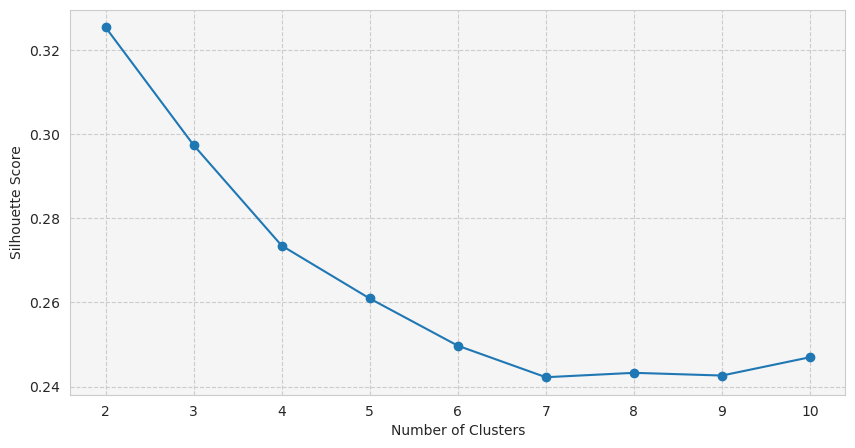

In [64]:
# 클러스터별 통계 분석
cluster_stats = selected_df.groupby('cluster').agg({
    "총_유동인구_수": 'mean',
    "청년층_유동인구_비율": 'mean',
    "청년_매출_비율": 'mean',
    "주말_매출_비율": 'mean',
    "야간유동인구비율": 'mean',
    "점포당_월매출액": 'mean',
    "객단가": 'mean',
    "개업_율": 'mean',
    "프랜차이즈_점포_비율": 'mean',
}).round(2)

# 각 클러스터별 샘플 데이터 확인 (각 클러스터에서 3개씩)
cluster_samples = {}
for cluster in selected_df['cluster'].unique():
    cluster_samples[cluster] = selected_df[selected_df['cluster'] == cluster].sample(10)

# 결과 출력
print("=== 클러스터별 평균 통계 ===")
display(cluster_stats)

print("\n=== 클러스터별 샘플 데이터 (원래 스케일) ===")
for cluster, samples in cluster_samples.items():
    print(f"\n클러스터 {cluster}의 샘플:")
    display(samples)

# 각 클러스터별 구 분포 분석
print("\n=== 클러스터별 구 분포 (상위 3개) ===")
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    # 행정동 코드의 앞 5자리가 구 코드
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    print(f"\n클러스터 {cluster}의 주요 구:")
    for gu_code, count in gu_counts.head(3).items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        print(f"- {gu_name}: {count}개 행정동")

#  실루엣 계수
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca3)
    labels = kmeans.labels_
    score = silhouette_score(X_pca3, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

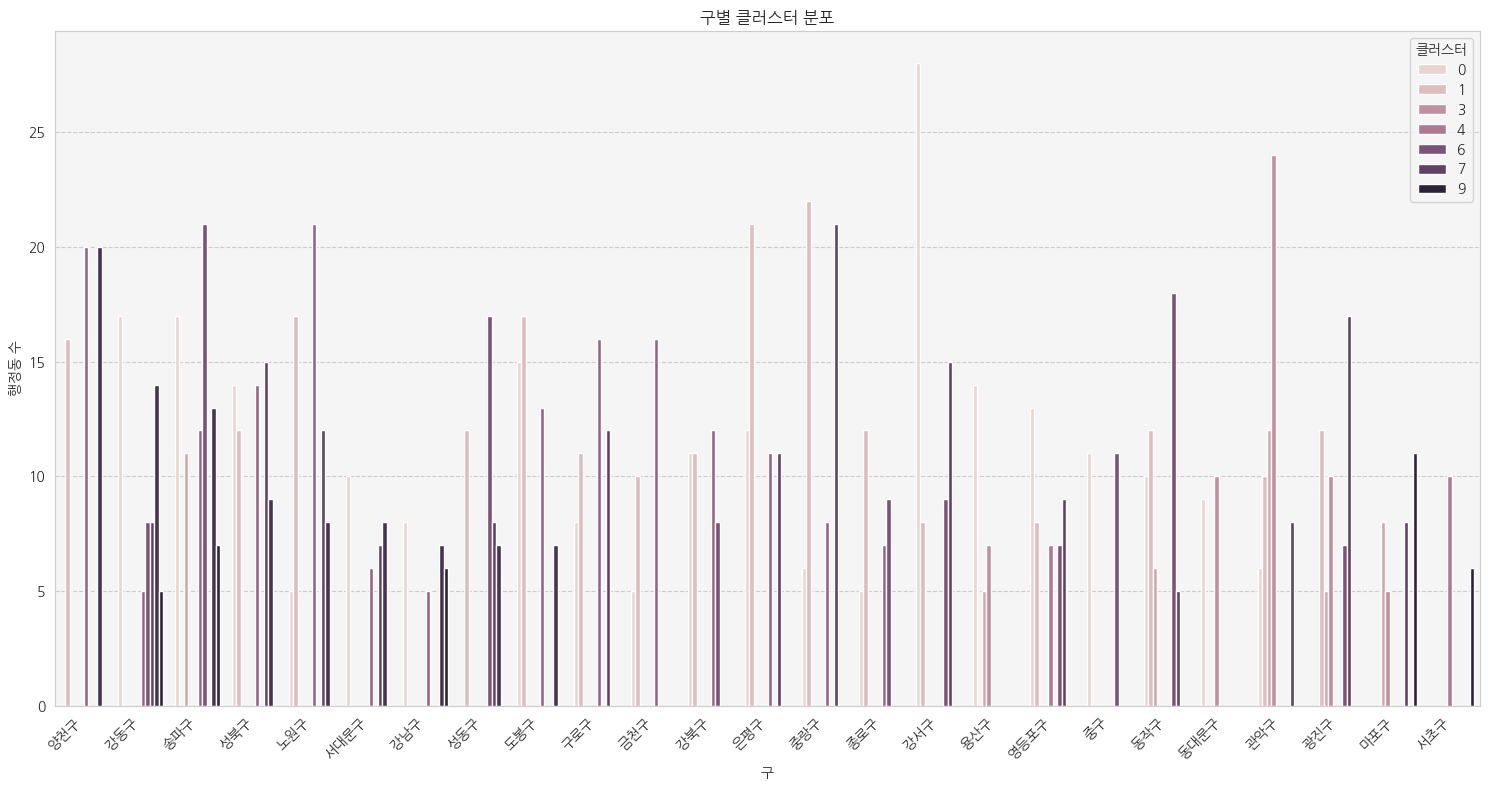

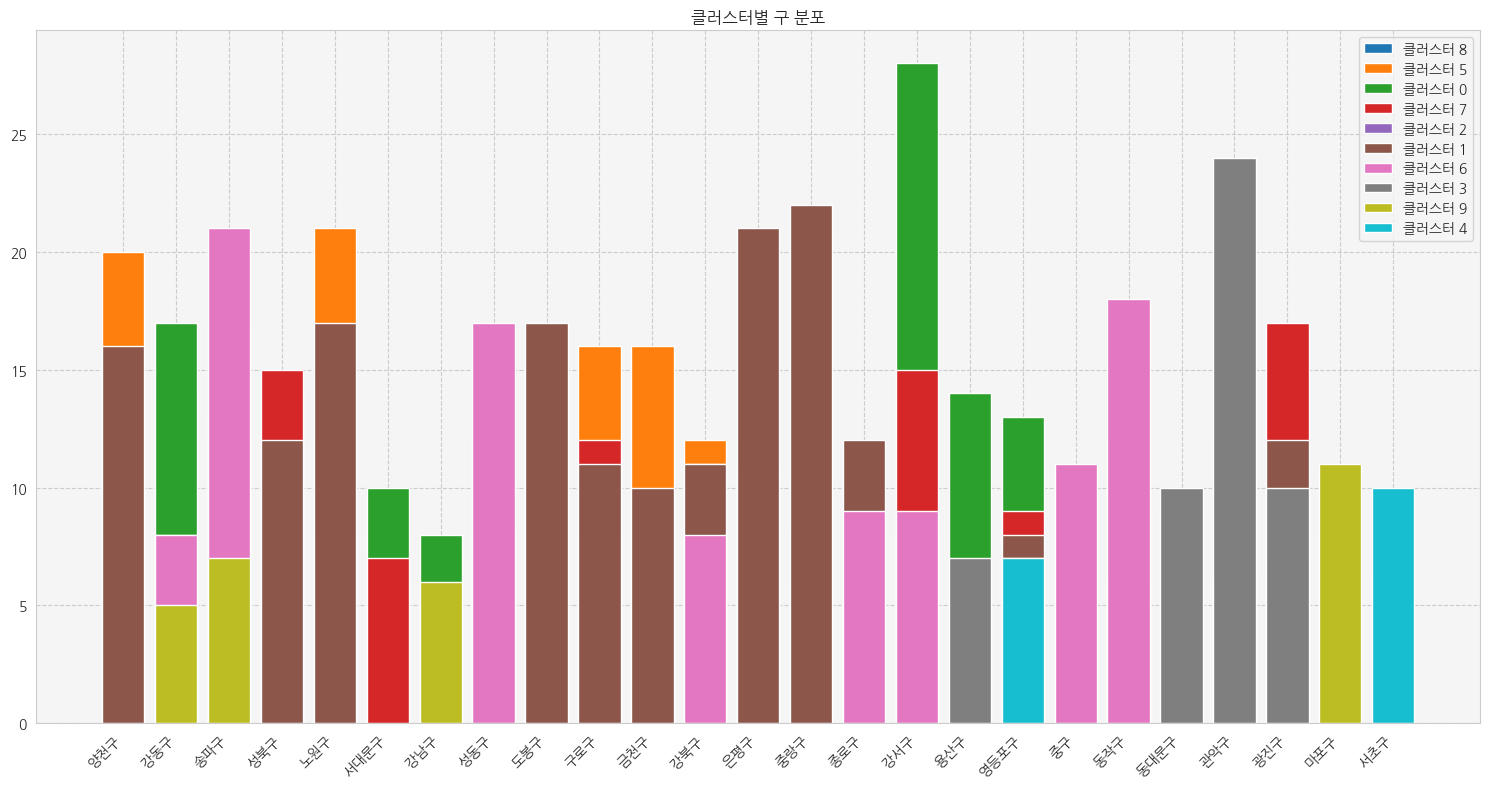

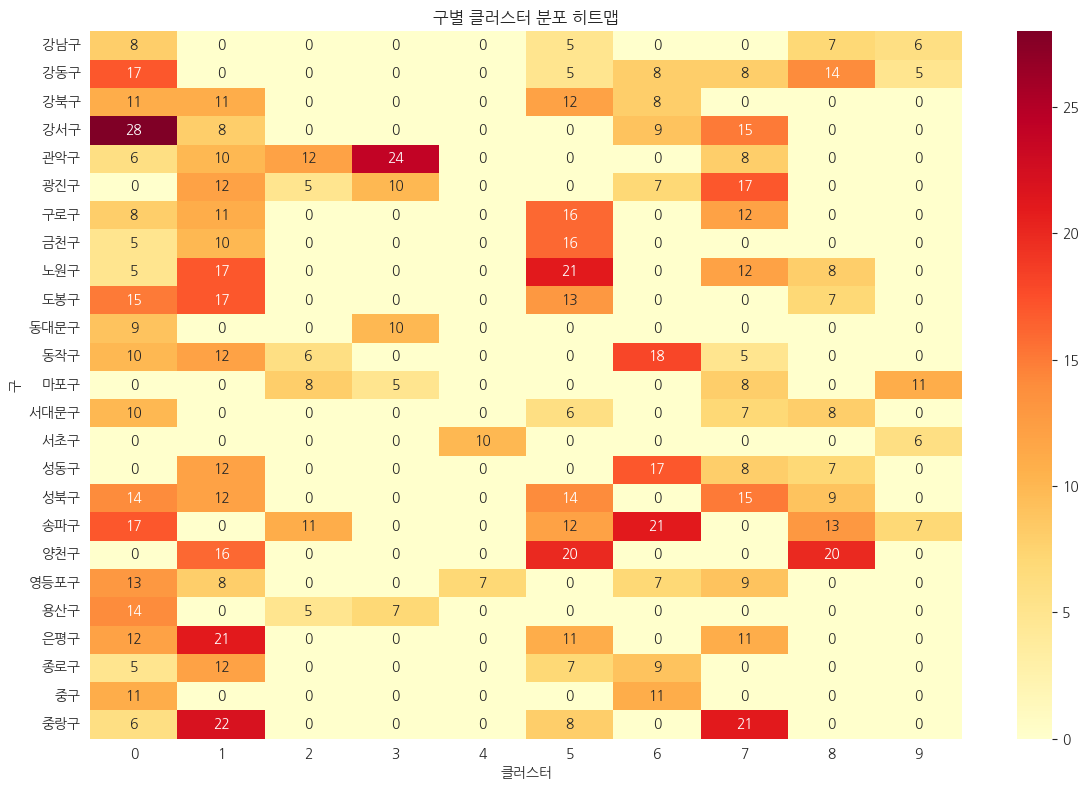

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd

# 각 클러스터별 구 분포 분석 및 필터링
cluster_gu_counts = {}
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    # 최소 5개 이상인 구만 선택
    significant_gu = gu_counts[gu_counts >= 5]
    cluster_gu_counts[cluster] = significant_gu

# 각 구별 클러스터 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 구별 클러스터 분포 데이터 생성
gu_cluster_data = []
for cluster, gu_counts in cluster_gu_counts.items():
    for gu_code, count in gu_counts.items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        gu_cluster_data.append({
            '구': gu_name,
            '클러스터': cluster,
            '행정동 수': count
        })

gu_cluster_df = pd.DataFrame(gu_cluster_data)

# 시각화
plt.figure(figsize=(15, 8))
sns.barplot(data=gu_cluster_df, x='구', y='행정동 수', hue='클러스터')
plt.xticks(rotation=45, ha='right')
plt.title('구별 클러스터 분포')
plt.tight_layout()
plt.show()

# 각 클러스터별 주요 구 시각화
plt.figure(figsize=(15, 8))
for cluster in selected_df['cluster'].unique():
    cluster_data = gu_cluster_df[gu_cluster_df['클러스터'] == cluster]
    plt.bar(cluster_data['구'], cluster_data['행정동 수'], label=f'클러스터 {cluster}')

plt.xticks(rotation=45, ha='right')
plt.title('클러스터별 구 분포')
plt.legend()
plt.tight_layout()
plt.show()

# 히트맵으로 시각화
pivot_df = gu_cluster_df.pivot(index='구', columns='클러스터', values='행정동 수').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('구별 클러스터 분포 히트맵')
plt.tight_layout()
plt.show()

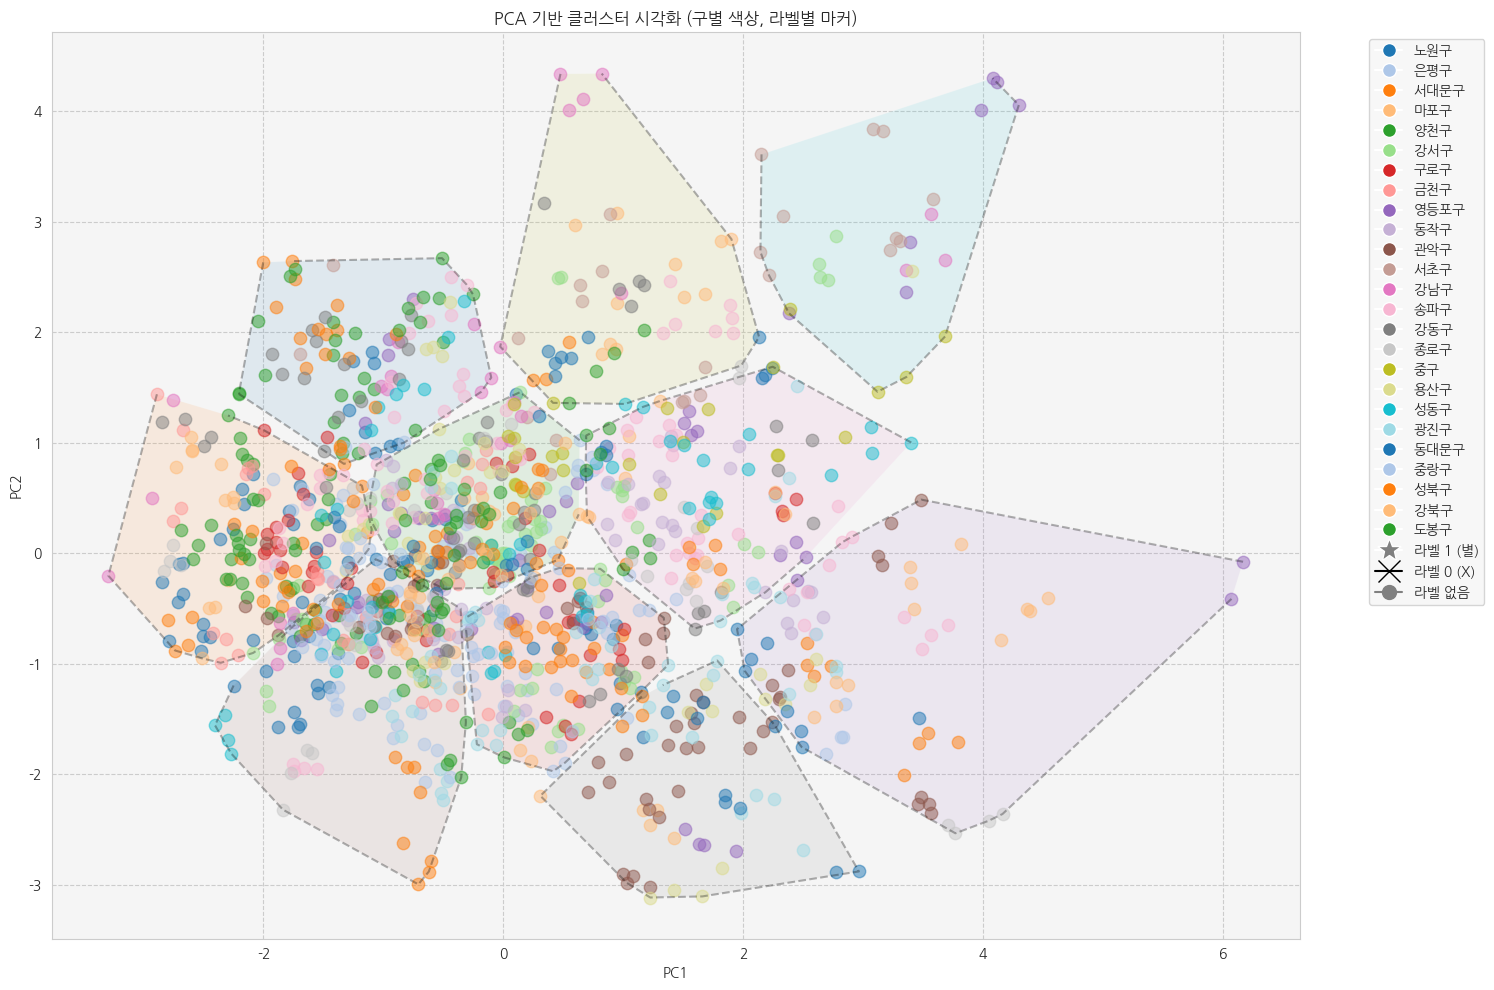

In [66]:
# 라벨링된 데이터 추가

import pandas as pd
from scipy.spatial import ConvexHull

# label.xlsx에서 라벨 정보 읽기
label_df = pd.read_excel('label.xlsx')

label_map = dict(zip(label_df['행정동_코드'], label_df['라벨']))

# selected_df에 라벨 컬럼 추가 (없으면 NaN)
selected_df['라벨'] = selected_df['행정동_코드'].map(label_map)

plt.figure(figsize=(15, 10))

unique_gu_codes = selected_df['행정동_코드'].astype(str).str[:5].unique()
gu_colors = {gu_code: plt.cm.tab20(i % 20) for i, gu_code in enumerate(unique_gu_codes)}

for cluster in selected_df['cluster'].unique():
    cluster_mask = selected_df['cluster'] == cluster
    cluster_points = X_pca2[cluster_mask]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        plt.plot(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 'k--', alpha=0.3)
        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.1)
    
    for gu_code in unique_gu_codes:
        gu_mask = selected_df['행정동_코드'].astype(str).str[:5] == gu_code
        combined_mask = cluster_mask & gu_mask
        # 라벨별로 마커 다르게
        star_mask = combined_mask & (selected_df['라벨'] == 1)
        x_mask = combined_mask & (selected_df['라벨'] == 0)
        none_mask = combined_mask & (selected_df['라벨'].isna())
        if star_mask.any():
            plt.scatter(
                X_pca2[star_mask, 0],
                X_pca2[star_mask, 1],
                c=[gu_colors[gu_code]],
                marker='*',
                s=600,                # 훨씬 크게!
                edgecolor='black',
                linewidths=2.5,       # 두꺼운 테두리
                alpha=1.0,
                zorder=10,
                label=None
            )
        if x_mask.any():
            plt.scatter(
                X_pca2[x_mask, 0],
                X_pca2[x_mask, 1],
                c=[gu_colors[gu_code]],
                marker='x',
                s=400,                # 훨씬 크게!
                edgecolor='black',
                linewidths=4,         # 두꺼운 테두리
                alpha=1.0,
                zorder=9,
                label=None
            )
        if none_mask.any():
            plt.scatter(
                X_pca2[none_mask, 0],
                X_pca2[none_mask, 1],
                c=[gu_colors[gu_code]],
                marker='o',
                s=80,
                alpha=0.5,
                zorder=1,
                label=None
            )

# 범례 추가 (구별 색상)
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=gu_colors[gu_code], 
                     markersize=10, 
                     label=seoul_gu_code_map.get(gu_code, "알 수 없음"))
          for gu_code in unique_gu_codes]

# 마커별 범례 추가
handles += [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=18, label='라벨 1 (별)'),
    plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', markersize=16, label='라벨 0 (X)'),
    plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='gray', markersize=10, label='라벨 없음')
]

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA 기반 클러스터 시각화 (구별 색상, 라벨별 마커)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [67]:
# 라벨된 데이터들 확인하기

selected_df['행정동_코드'] = selected_df['행정동_코드'].astype(str)
label_df['행정동_코드'] = label_df['행정동_코드'].astype(str)

# 다시 라벨 매핑
selected_df['라벨'] = selected_df['행정동_코드'].map(dict(zip(label_df['행정동_코드'], label_df['라벨'])))
print(selected_df['라벨'].value_counts(dropna=False))
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]
print(len(labeled_df))
print(labeled_df[['행정동_코드', '라벨']].head())

# 라벨이 있는 데이터만 추출
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]

# 각 라벨별로 클러스터 분포 출력
for label_value in [0.0, 1.0]:
    print(f"\n라벨 {label_value}인 데이터의 클러스터 분포:")
    label_cluster_counts = labeled_df[labeled_df['라벨'] == label_value]['cluster'].value_counts().sort_index()
    for cluster, count in label_cluster_counts.items():
        print(f"  클러스터 {cluster}: {count}개")

라벨
NaN    820
0.0    388
1.0    101
Name: count, dtype: int64
489
      행정동_코드   라벨
0   11350619  1.0
6   11350665  0.0
8   11350695  0.0
14  11380530  0.0
16  11380552  0.0

라벨 0.0인 데이터의 클러스터 분포:
  클러스터 0: 65개
  클러스터 1: 80개
  클러스터 2: 15개
  클러스터 3: 27개
  클러스터 4: 12개
  클러스터 5: 55개
  클러스터 6: 54개
  클러스터 7: 47개
  클러스터 8: 21개
  클러스터 9: 12개

라벨 1.0인 데이터의 클러스터 분포:
  클러스터 0: 18개
  클러스터 1: 15개
  클러스터 2: 14개
  클러스터 3: 12개
  클러스터 4: 4개
  클러스터 5: 7개
  클러스터 6: 14개
  클러스터 7: 8개
  클러스터 8: 7개
  클러스터 9: 2개


In [68]:
# 클러스터별 1.0, 0.0 개수와 비율 출력
print("클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):")
for cluster in sorted(labeled_df['cluster'].unique()):
    cluster_data = labeled_df[labeled_df['cluster'] == cluster]
    count_1 = (cluster_data['라벨'] == 1.0).sum()
    count_0 = (cluster_data['라벨'] == 0.0).sum()
    ratio = count_1 / count_0 if count_0 > 0 else float('inf')
    print(f"클러스터 {cluster}: 1.0 = {count_1}, 0.0 = {count_0}, 비율(1.0/0.0) = {ratio:.2f}")

클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):
클러스터 0: 1.0 = 18, 0.0 = 65, 비율(1.0/0.0) = 0.28
클러스터 1: 1.0 = 15, 0.0 = 80, 비율(1.0/0.0) = 0.19
클러스터 2: 1.0 = 14, 0.0 = 15, 비율(1.0/0.0) = 0.93
클러스터 3: 1.0 = 12, 0.0 = 27, 비율(1.0/0.0) = 0.44
클러스터 4: 1.0 = 4, 0.0 = 12, 비율(1.0/0.0) = 0.33
클러스터 5: 1.0 = 7, 0.0 = 55, 비율(1.0/0.0) = 0.13
클러스터 6: 1.0 = 14, 0.0 = 54, 비율(1.0/0.0) = 0.26
클러스터 7: 1.0 = 8, 0.0 = 47, 비율(1.0/0.0) = 0.17
클러스터 8: 1.0 = 7, 0.0 = 21, 비율(1.0/0.0) = 0.33
클러스터 9: 1.0 = 2, 0.0 = 12, 비율(1.0/0.0) = 0.17


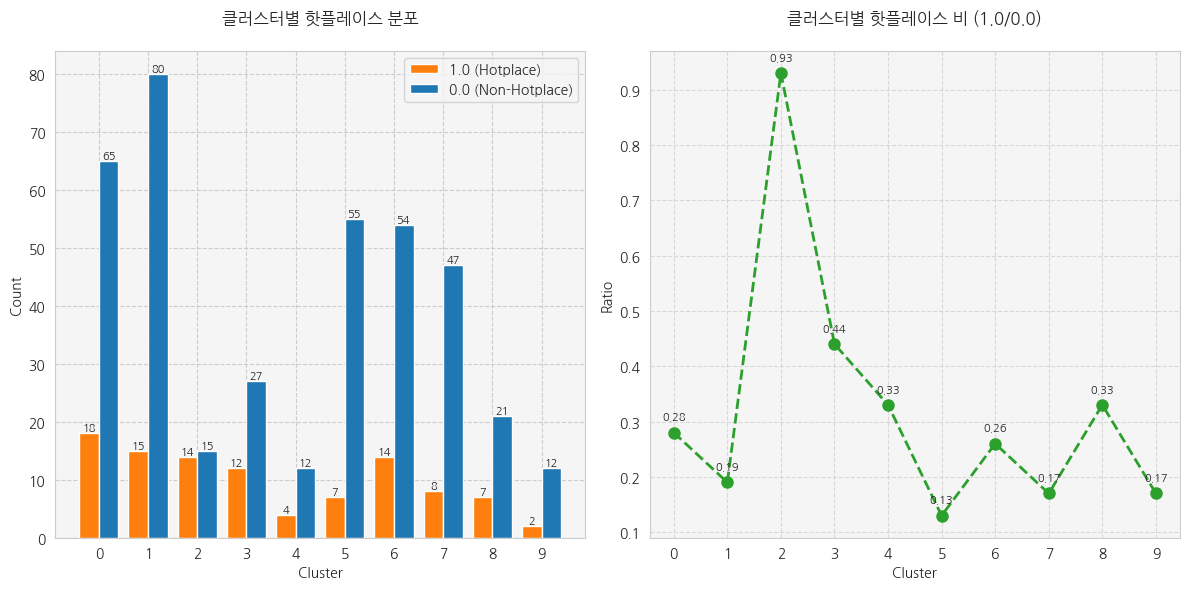

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
count_1 = [18, 15, 14, 12, 4, 7, 14, 8, 7, 2]
count_0 = [65, 80, 15, 27, 12, 55, 54, 47, 21, 12]
ratios = [0.28, 0.19, 0.93, 0.44, 0.33, 0.13, 0.26, 0.17, 0.33, 0.17]

# Figure 설정
plt.figure(figsize=(12, 6))
x = np.arange(len(clusters))

# 1) 막대 그래프 (1.0 vs 0.0 개수 비교)
plt.subplot(1, 2, 1)
bar1 = plt.bar(x - 0.2, count_1, 0.4, label='1.0 (Hotplace)', color='#ff7f0e')
bar2 = plt.bar(x + 0.2, count_0, 0.4, label='0.0 (Non-Hotplace)', color='#1f77b4')

plt.title('클러스터별 핫플레이스 분포', fontsize=12, pad=20)
plt.xlabel('Cluster', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(x, clusters)
plt.legend()

# 막대 위에 수치 표시
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=8)

# 2) 비율 추이 라인 그래프
plt.subplot(1, 2, 2)
line = plt.plot(clusters, ratios, marker='o', 
                linestyle='--', color='#2ca02c', 
                markersize=8, linewidth=2)

plt.title('클러스터별 핫플레이스 비 (1.0/0.0)', fontsize=12, pad=20)
plt.xlabel('Cluster', fontsize=10)
plt.ylabel('Ratio', fontsize=10)
plt.xticks(clusters)
plt.grid(True, linestyle='--', alpha=0.7)

# 비율 값 표시
for i, ratio in enumerate(ratios):
    plt.text(clusters[i], ratio+0.02, f'{ratio:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [70]:
# 클러스터2 데이터 추출
print(selected_df[selected_df['cluster'] == 2]['행정동_코드'].value_counts())

행정동_코드
11350640    4
11710562    4
11305635    4
11290575    4
11260590    4
11215730    4
11410615    4
11110650    4
11710650    4
11170555    4
11620725    4
11620615    4
11620595    4
11590620    4
11440680    4
11440600    4
11230720    3
11710580    3
11560535    2
11590530    2
11170660    1
11215850    1
11230710    1
11560560    1
Name: count, dtype: int64
